# Compare models with diff delays

In [2]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [12]:
mouse_id = 'Mouse12'
session_id = '120806'
phase = 'wake'
subset = 'hdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/' 

In [13]:
dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-eq-2',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

units:  85  hdc units:  22


In [14]:
units_used = dataset_dict['neurons']
rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)
 

hd_sweep = torch.linspace(0, 2*np.pi, 100)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

delay -3, LL = -208694.9375
delay -2, LL = -196029.13504464287
delay -1, LL = -188915.76785714287
delay 0, LL = -189694.4720982143
delay 1, LL = -199973.95982142858
delay 2, LL = -210440.98549107142
delay 3, LL = -217992.3950892857


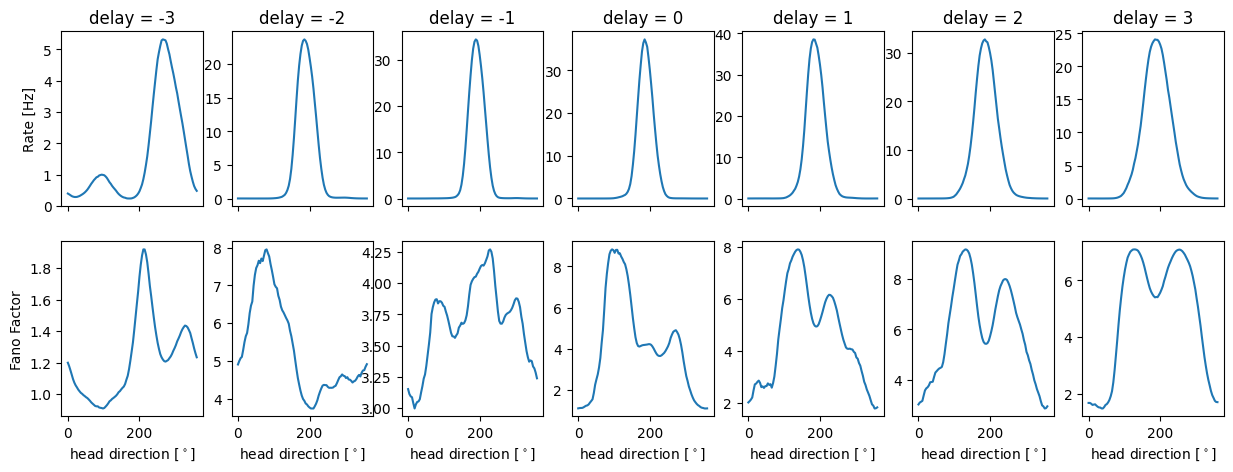

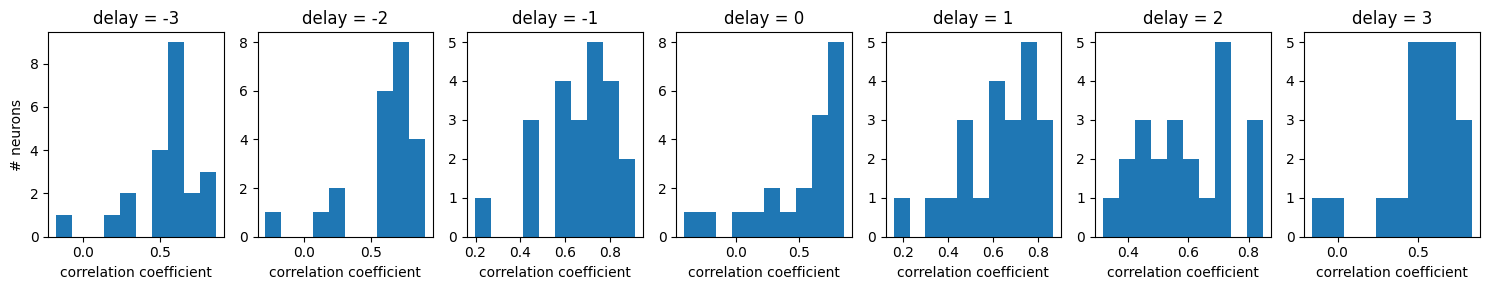

In [15]:
ne=12
angles = np.linspace(0, 360, hd_sweep.shape[-1])

delays = [-3, -2, -1, 0, 1, 2, 3]
model_dict['delays'] = delays

fig1, ax1 = plt.subplots(2, len(delays), figsize = (15,5), sharex=True)
ax1[0, 0].set_ylabel('Rate [Hz]')
ax1[1, 0].set_ylabel('Fano Factor')

fig2, ax2 = plt.subplots(1, len(delays), figsize=(15,3))
ax2[0].set_ylabel('# neurons')


for i, delay in enumerate(delays):
    modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)

    ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0)
    print(f'delay {delay}, LL = {ll}')
    
    with torch.no_grad():
        P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
    P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)   

    K = P_mc.shape[-1]
    counts = torch.arange(K)

    hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
    hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
    hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2 
    hd_FF = hd_var / (hd_mean + 1e-12)

    _, hd_rate, _ = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])  # (neurons, steps)
    _, hd_FF, _ = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])


    ax1[0, i].plot(angles, hd_rate[ne, :])
    ax1[1, i].plot(angles, hd_FF[ne, :])
    ax1[1, i].set_xlabel('head direction [$^\circ$]')
    ax1[0, i].set_title(f'delay = {delay}')


    correlations = np.empty((0,))
    for ne in range(units_used):
        C = np.corrcoef(np.gradient(hd_rate[ne,:])**2, hd_FF[ne,:])
        correlations = np.append(correlations, C[0,1])


    ax2[i].hist(correlations, bins=10)
    ax2[i].set_xlabel('correlation coefficient')
    ax2[i].set_title(f'delay = {delay}')

plt.tight_layout()

delay -3, LL = -226209.03236607142
delay -2, LL = -218193.18080357142
delay -1, LL = -207650.08370535713
delay 0, LL = -202811.6908482143
delay 1, LL = -211337.79575892858
delay 2, LL = -220660.58705357142
delay 3, LL = -227618.55357142858


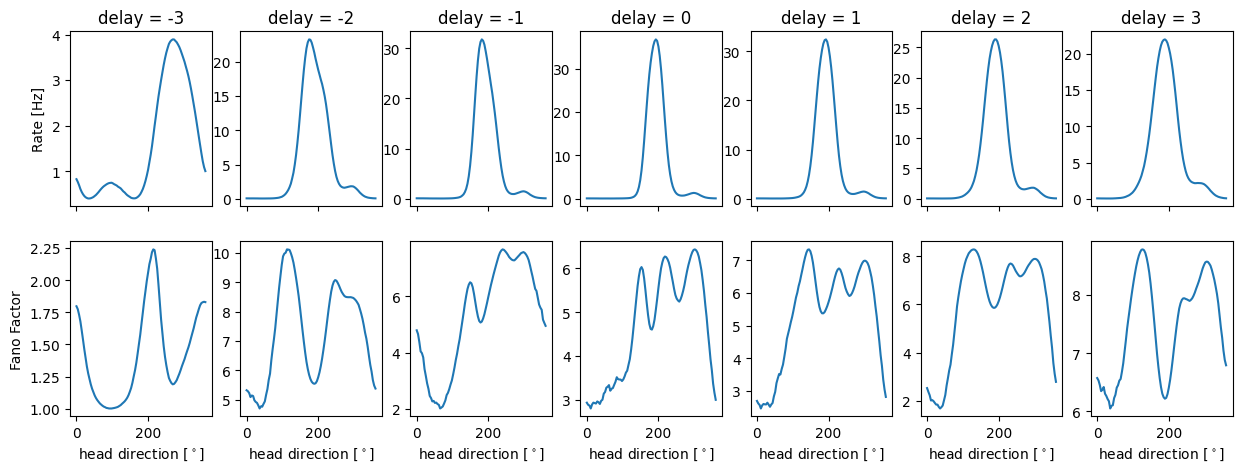

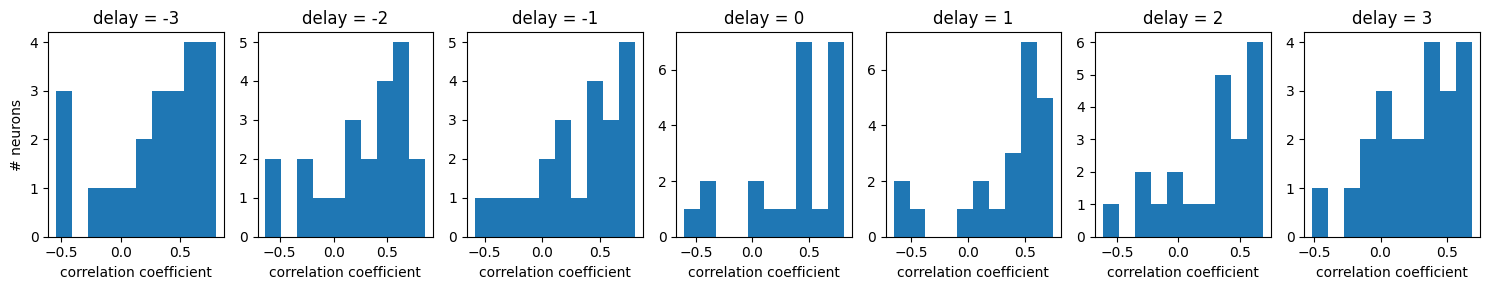

In [18]:
ne=12

model_dict['x_mode'] = 'hd'
angles = np.linspace(0, 360, hd_sweep.shape[-1])

delays = [-3, -2, -1, 0, 1, 2, 3]
model_dict['delays'] = delays

fig1, ax1 = plt.subplots(2, len(delays), figsize = (15,5), sharex=True)
ax1[0, 0].set_ylabel('Rate [Hz]')
ax1[1, 0].set_ylabel('Fano Factor')

fig2, ax2 = plt.subplots(1, len(delays), figsize=(15,3))
ax2[0].set_ylabel('# neurons')


for i, delay in enumerate(delays):
    modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)

    ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0)
    print(f'delay {delay}, LL = {ll}')
    
    covariates=hd_sweep[None, None, :, None]
    with torch.no_grad():
        P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
    P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)   

    K = P_mc.shape[-1]
    counts = torch.arange(K)

    hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
    hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
    hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2 
    hd_FF = hd_var / (hd_mean + 1e-12)

    _, hd_rate, _ = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])  # (neurons, steps)
    _, hd_FF, _ = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])


    ax1[0, i].plot(angles, hd_rate[ne, :])
    ax1[1, i].plot(angles, hd_FF[ne, :])
    ax1[1, i].set_xlabel('head direction [$^\circ$]')
    ax1[0, i].set_title(f'delay = {delay}')


    correlations = np.empty((0,))
    for ne in range(units_used):
        C = np.corrcoef(np.gradient(hd_rate[ne,:])**2, hd_FF[ne,:])
        correlations = np.append(correlations, C[0,1])


    ax2[i].hist(correlations, bins=10)
    ax2[i].set_xlabel('correlation coefficient')
    ax2[i].set_title(f'delay = {delay}')

plt.tight_layout()

delay 0, LL = -189937.0078125


Text(0.5, 1.0, 'delay = 0')

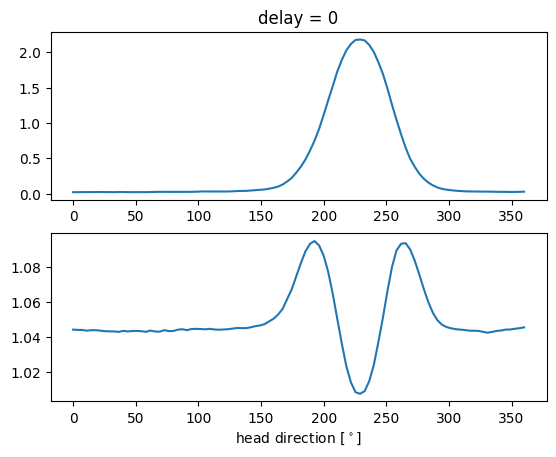

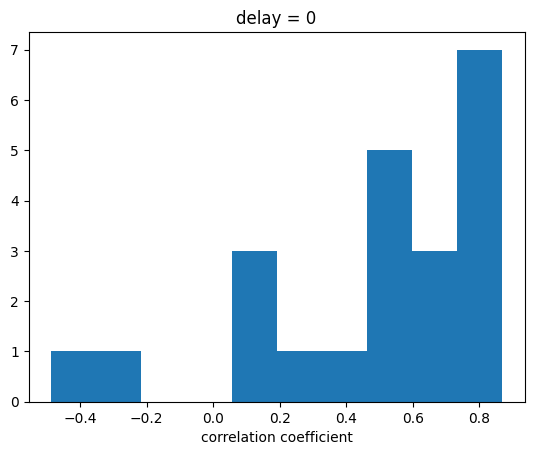

In [118]:
ne=0

model_dict['delays'] = [0]
delay=0

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)


ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0)
print(f'delay {delay}, LL = {ll}')
    

with torch.no_grad():
    P_mc = lib.helper.compute_P(
    modelfit, covariates, list(range(units_used)), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  # count probabilities of shape (MC, neurons, steps, count)   

K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

_, hd_rate, _ = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
_, hd_FF, _ = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])

fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(angles, hd_rate[ne, :])
ax1[1].plot(angles, hd_FF[ne, :])
ax1[1].set_xlabel('head direction [$^\circ$]')
ax1[0].set_title(f'delay = {delay}')


correlations = np.empty((0,))
for ne in range(units_used):
    C = np.corrcoef(np.gradient(hd_rate[ne,:])**2, hd_FF[ne,:])
    correlations = np.append(correlations, C[0,1])

fig2, ax2 = plt.subplots()
ax2.hist(correlations, bins=10)
ax2.set_xlabel('correlation coefficient')
ax2.set_title(f'delay = {delay}')

# Estimating Fisher information

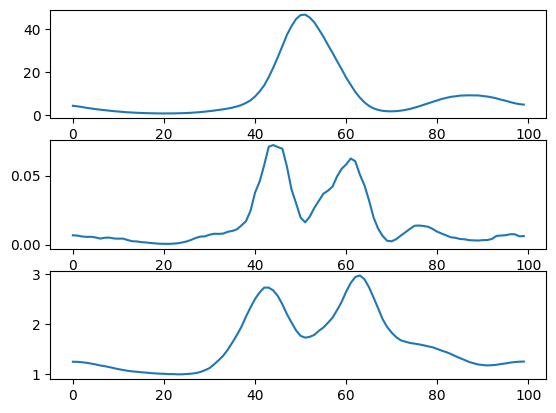

In [125]:
n = 2

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

[hd_rate] = utils.signal.percentiles_from_samples(hd_rate, [0.5])
[hd_FF] = utils.signal.percentiles_from_samples(hd_FF, [0.5])

fig, ax = plt.subplots(3,1)
ax[0].plot(hd_rate[n])


grad = torch.gradient(torch.nan_to_num(torch.log(P_mc), neginf=0.0), dim=2)
grad = grad[0]

[fisher] = utils.signal.percentiles_from_samples((grad**2 * P_mc).sum(-1), [0.5])
ax[1].plot(fisher[n])

ax[2].plot(hd_FF[n])


## Poisson example

In [77]:

r_max = 10
s_preffered = np.pi
sigma_preffered = np.pi/4
T=1

def rate(s): 
    return r_max * np.exp(-0.5 * (s - s_preffered)**2 / sigma_preffered)

inputs = np.linspace(0, 2*np.pi, 100)

r_avg = np.mean(rate(inputs))
print(r_avg)

def prob(r, s): 
    return np.exp(-rate(s))*(rate(s)**r) / (np.math.factorial(r))

rs = np.arange(0, 29)
probs = np.empty((inputs.size, rs.size))

for i, r in enumerate(rs):
    for j, s in enumerate(inputs):
        probs[j, i] = prob(r, s)

3.4989827190731675


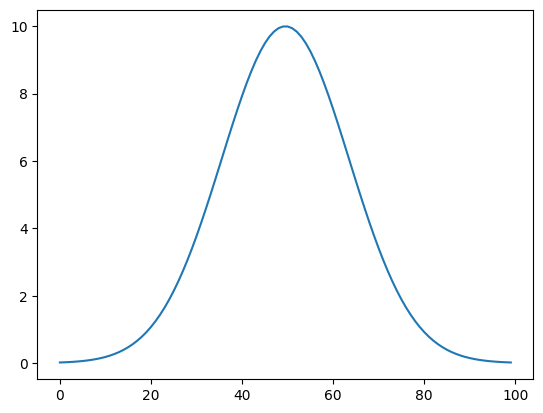

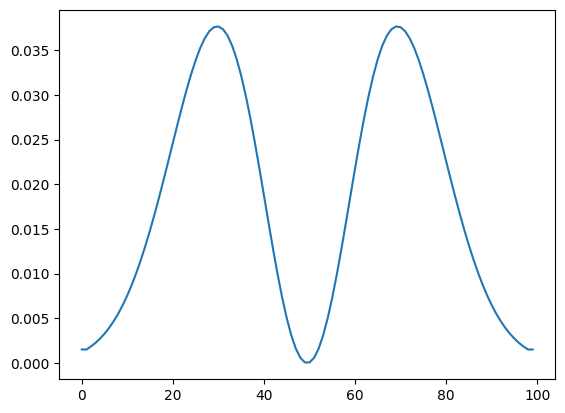

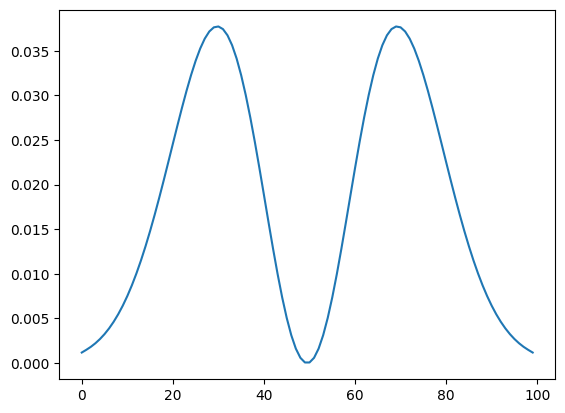

In [89]:
mean = (rs[None, :] * probs).sum(-1)
plt.plot(mean)
plt.show()

fisher = (np.gradient(rate(inputs))**2 / rate(inputs))
plt.plot(fisher)
plt.show()

grad = np.gradient(np.log(probs), axis=0)
fisher = (grad**2 * probs).sum(-1)
plt.plot(fisher)
plt.show()

